# Introduction
This notebook build a workflow to predict a popularity score for Steam games using pre-release metadata.
In summary, we run some EDA, implement transformations in a **sklearn pipeline**, run `RandomizedSearchCV` for hyperparameter tuning of different models (DecisionTree, RandomForests, XGBoost), and produce interpretation plots with feature importance.
Dataset used:
Artemiy Ermilov, Arina Nevolina, Artem Pospelov, and Assol Kubaeva. (2025). Steam Games Dataset 2025 [Data set]. Kaggle. https://doi.org/10.34740/KAGGLE/DSV/11017460


```
#| eval: false
# Download Dataset
!curl -L -O https://www.kaggle.com/api/v1/datasets/download/artermiloff/steam-games-dataset
!mv steam-games-dataset steam-games-dataset.zip

!unzip -l steam-games-dataset.zip

!unzip steam-games-dataset.zip games_march2025_cleaned.csv -d data
!rm steam-games-dataset.zip
```

# Load Data

In [ ]:
import pandas as pd
import numpy as np
np.random.seed(123)

data = pd.read_csv('data/games_march2025_cleaned.csv')

In [ ]:
print(f'{data.shape} \n\n {data.head(3).T} \n\n {data.dtypes} \n\n {data.isna().sum().sort_values(ascending=False)}')

(89618, 47) 

                                                                           0  ...                                                  2
appid                                                                   730  ...                                                570
name                                                       Counter-Strike 2  ...                                             Dota 2
release_date                                                     2012-08-21  ...                                         2013-07-09
required_age                                                              0  ...                                                  0
price                                                                   0.0  ...                                                0.0
dlc_count                                                                 1  ...                                                  2
detailed_description      For over two decades, Counter-Strik

# Data Cleaning
## Removing unused columns
Since this is aimed at using pre-release data, there are some columns from the dataset that are not needed
* Columns such as `appid`, `name`, `detailed_description`, `about_the_game`, `reviews`, `metacritic_url`, `notes`, `image`, `screenshot`, `movies` and so on are only long text descriptors or media urls.
    * in this case they add complexity without adding benefit, so they will be removed
    * tags will also be removed for simplicity
* Metrics that are collected post launch will be removed
    * these would add data leakage inside the model, i.e., the model would use say number of owners and players to estimate if a unreleased game would do well
    * instead, this will be the outcome variable

In [ ]:
cols_keep = ['name','discount','release_date', 'required_age', 'price', 'dlc_count', 'windows', 'mac', 'linux', 'developers', 'publishers', 'categories', 'genres', 'positive', 'negative', 'estimated_owners']

df = data.copy()
df = df[cols_keep]

## Parsing `estimated_owners`
We need to take care of the `estimated_owners` variable.
It comes in the format as a string in the form `[100000000 - 200000000]` for example. This information will be processesd as follows:
* strip the string
* take the average of the two numbers
* output it as float

<Axes: xlabel='estimated_owners', ylabel='Count'>

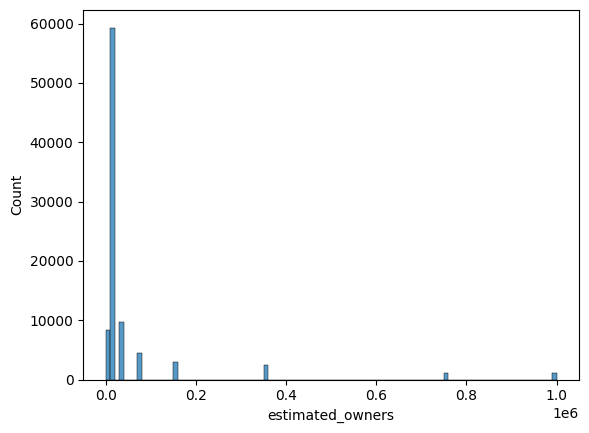

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

df['estimated_owners'] = df['estimated_owners'].str.split(' - ')\
    .apply(lambda x: (float(x[0])+float(x[1]))/len(x))

sns.histplot(df.estimated_owners.clip(upper=1000000), bins=100) #long tail, will need to be log transformed

## Removing duplicates
There are repeated games. Some have the same name and are different (different developer, publisher), but others have the same of everything (dlcs probably) but there is no variable that gives if it is a dlc or not.
So to fix that:
* group per name, release date, publisher, developers
* take the one with the highest mean estimated owners (proxy for base game)

In [ ]:
df = df.loc[
    df.groupby(['name', 'release_date', 'developers', 'publishers'])['estimated_owners'].idxmax()
].reset_index(drop=True)

## Remove rows where all values are empty
Remove instances where all 4 columns (genres, categories, publishers and developers) are empty
These are mostly alpha and beta testing, unlisted games and unknowns

In [ ]:
mask = (
    (df['genres'].apply(len).gt(0)) |
    (df['categories'].apply(len).gt(0)) |
    (df['developers'].apply(len).gt(0)) |
    (df['publishers'].apply(len).gt(0))
)
df = df[mask]

## Parsing strings
Among the columns used, there are some which are read as strings, but should be python lists.
These include `genres`, `categories`, `developers` and `publishers`

In [ ]:
import ast
cat_lists = ['genres', 'categories', 'developers', 'publishers']
for var in cat_lists:
    df[var] = df[var].apply(ast.literal_eval)

## Replace empty lists with `["None"]`
In instances where not all values are missing:

* replace empty lists with "None"

In [ ]:
def normalize_list(x):
    if not isinstance(x, list) or len(x) == 0:
        return ["None"]
    return x

for var in cat_lists:
    df[var] = df[var].apply(normalize_list)

# Feature Engineering
Since this is aimed at predicting the success of a game, there are some variables which could be used as outcome.
We have `estimated_owners`  and `positive` and `negative` counts.
Since AAA games would likely have the most owners compared to more niche and Indie games, and the same for the number of positive and negative counts, the target variable can instead combine both
Steps:
* Remove extreme prices
* Create `pos_ratio=(positive+1)/(positive+negative+2)`
* Create target variable

In order to avoid favouring AAA games, the target variable will be in the form of:
`target = estimated_owners * pos_ratio`
Since these are also long tailed, they will be preprocessed with `np.log1p`

## Remove extreme prices
A new AAA game can cost around 80. But the range here is much larger

<Axes: xlabel='price', ylabel='Count'>

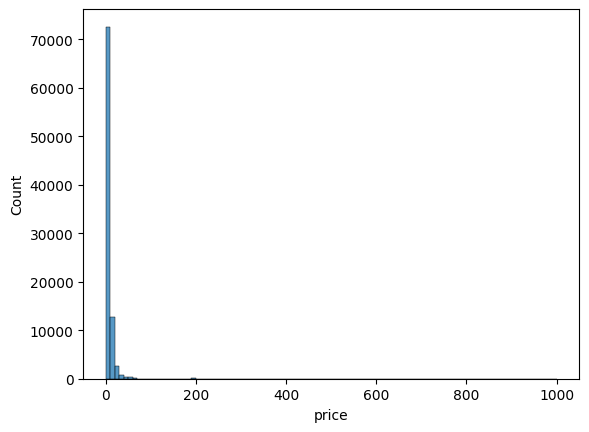

In [ ]:
sns.histplot(df.price, bins=100)

So we can remove rows with prices above 80

In [ ]:
print(df.price.describe())

df = df[df.price.le(80)]

count    89586.000000
mean         7.305636
std         13.326556
min          0.000000
25%          0.990000
50%          4.990000
75%          9.990000
max        999.980000
Name: price, dtype: float64


## Create positive ratio with Laplace smoothing
Investigate the distribution of `positive` and `negative` counts

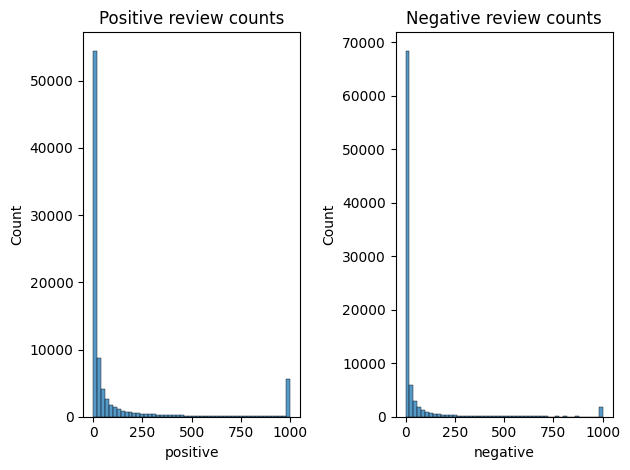

In [ ]:
fig, axes = plt.subplots(1, 2)
sns.histplot(df['positive'].clip(upper=1000), bins=50, ax=axes[0])
axes[0].set_title("Positive review counts")
sns.histplot(df['negative'].clip(upper=1000), bins=50, ax=axes[1])
axes[1].set_title("Negative review counts")
plt.tight_layout()

Now create the `pos_ratio` variable

<Axes: xlabel='pos_ratio', ylabel='Count'>

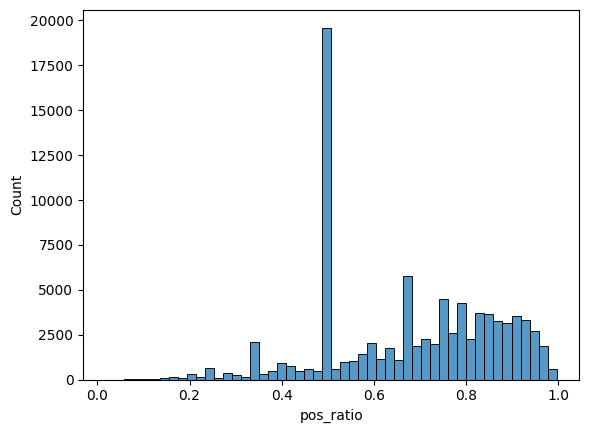

In [ ]:
df = df.assign(
    pos_ratio = (df.positive+1)/(df.positive+df.negative+2), # adding 1 to each positive and negative to avoid division by 0 (laplace smoothing). also treats games with 0 reviews as neutral, since they would have a score of 0.5
    )

sns.histplot(df.pos_ratio, bins=50)

## Create `target` variable
Now that we have the `pos_ratio` we can create the target variable 
`target = estimated_owners * pos_ratio`

We will also need to remove the variables not utilized after

The distribution of the target variable has quite a wide range, going from 0 to 2.8e8
The standard deviation is also large.
For that reason, it could benefit from log1p transformation

In [ ]:
(df.estimated_owners*df.pos_ratio).describe()

count    8.936600e+04
mean     8.207188e+04
std      1.385170e+06
min      0.000000e+00
25%      5.000000e+03
50%      7.575758e+03
75%      9.700449e+03
max      2.855178e+08
dtype: float64

<Axes: xlabel='target', ylabel='Count'>

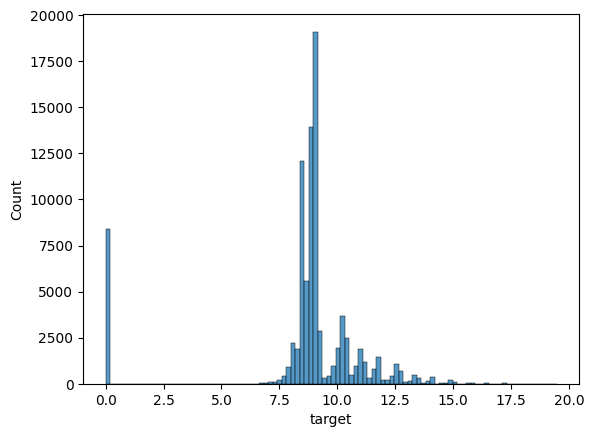

In [ ]:
df = df.assign(
    target = lambda x: np.log1p(x['estimated_owners']*x['pos_ratio'])
    ).drop(columns = ['name','positive', 'negative', 'estimated_owners', 'pos_ratio'])

sns.histplot(df.target, bins=100)

# Correlation
Let's have a look at how features are correlated
`mac` and `linux` have a moderate positive correlation, but that can be explained by both being unix-based systems, or that developers/publishers that decide to bring games to other platforms are more likely to publish in both.
`price` seems to be weakly correlated with the target variable

<Axes: >

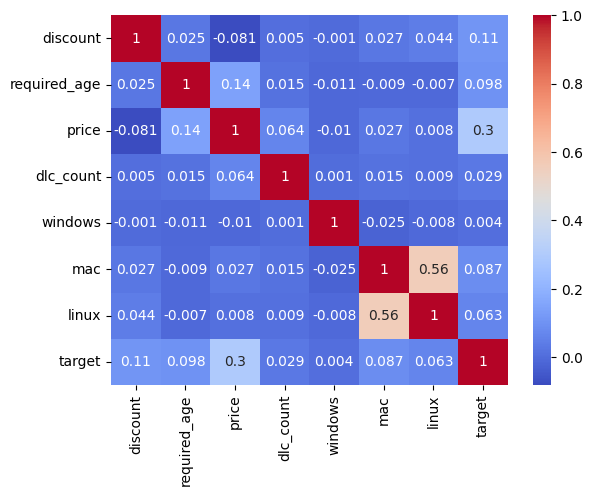

In [ ]:
%matplotlib inline
corr_matrix = df.select_dtypes(exclude='object').corr(numeric_only = True).round(3)

sns.heatmap(corr_matrix, cmap = 'coolwarm', annot = True)

# Additional Preprocessing Needed

There are some variables that still would need preprocessing:
* price: log1p transformation
* release_date: converted to datetime, and extract month, year, and days from release (dataset covers up to 2025.03.31)
* genres: remove some less frequent genres to reduce sparsity
* categories: remove some less frequent categories to reduce sparsity
* developers: frequency encoding
* publishers: frequency encoding

But since these variables will be used by the model, the processing will take place as transformers in the pipeline.

The frequency encoding serves to convert the publishers and developers columns to a ratio instead of names. That way it reduces sparsity by not having additional columns created on a Vectorizer, but keeps information, i.e., higher values indicate publishers/developers that produce more.

In [ ]:
print(df.publishers.explode().value_counts())
print()
print(df.developers.explode().value_counts())
print()
print(df.genres.explode().value_counts().head(10))
print()
print(df.categories.explode().value_counts().head(10))

publishers
None                     578
Big Fish Games           484
8floor                   237
EroticGamesClub          196
Conglomerate 5           186
                        ... 
High on Caffeine           1
Fireworks Productions      1
Good Face Team             1
BerCh1n                    1
RBL LABS                   1
Name: count, Length: 49779, dtype: int64

developers
None                        223
EroticGamesClub             196
Choice of Games             158
Laush Dmitriy Sergeevich    140
Boogygames Studios          133
                           ... 
Ultimate Walrus               1
Exit 73 Studios               1
High on Caffeine              1
StupidSimulators              1
Good Face Team                1
Name: count, Length: 60031, dtype: int64

genres
Indie           63070
Casual          38585
Action          36708
Adventure       35343
Simulation      18457
Strategy        17285
RPG             16286
Early Access     9099
Free To Play     8863
Sports           3

# Split the Data
Now that we have the target variable, we can move on to splitting the data

In [ ]:
from sklearn.model_selection import train_test_split
import joblib
with open('data/data_preprocessed.pkl', 'wb') as f:
    joblib.dump(df, f)

y = df.target
df = df.drop(columns='target')

df_full_train, df_test, y_full_train, y_test = train_test_split(df, y, random_state=123, test_size=0.2)
df_train, df_val, y_train, y_val = train_test_split(df_full_train, y_full_train, random_state=123, test_size=0.25)

# Define Transformers and Pipelines
We need the following transformers:
* Price
    * it applies log1p transformation on the price. Done via `FunctionTransformer`
* ReleaseDateTransformer
    * Parses `release_date` as `release_year`, `release_month` and `days_since_release`
* MLBTransformer
    * filter rare labels (below 1% frequency)
    * `genres` and `categories` are lists with multiple elements per entry
    * this is similar to DictVectorizer, but for multi label data
* FrequencyEncoder
    * frequency encoding for `publishers` and `developers`

## ReleaseDateTransformer

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

class ReleaseDateTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, reference_date='2025-03-31'):#database is from march 2025
        self.reference_date=pd.to_datetime(reference_date) 
    
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = pd.to_datetime(X, errors='coerce')
        X_df = pd.DataFrame({
            'release_year': X.dt.year,
            'release_month': X.dt.month,
            'days_since_release': (self.reference_date - X).dt.days
        })
        return X_df
    
    def get_feature_names_out(self, input_features=None):
        return np.array(['release_year', 'release_month', 'days_since_release'])

## MLBTransformer
This filters columns based on rare labels (below 1% frequency) and then applies a MultiLabelBinarizer
Importantly, the filter is only done based on the training data, to avoid data leakage

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer

class MLBTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, sparse_output=False, min_freq=0.01):
        self.sparse_output = sparse_output
        self.min_freq = min_freq
        self.mlb=None
        self.allowed_labels= None
    
    def fit(self, X, y=None):
        X = pd.Series(X)
        all_labels = X.explode().value_counts(normalize=True)
        self.allowed_labels=list(all_labels[all_labels >= self.min_freq].index)

        #filter the list
        X_filtered = X.apply(self._filter_labels)

        #now we can fit the MultiLabelBinarizer
        self.mlb = MultiLabelBinarizer(sparse_output=self.sparse_output)
        self.mlb.fit(X_filtered)
        return self

    def _filter_labels(self, lst):
        filtered = [x for x in lst if x in self.allowed_labels] or ['Other']
        return filtered
    
    def transform(self, X):
        X = pd.Series(X)
        X_filtered = X.apply(self._filter_labels)
        return self.mlb.transform(X_filtered)

    def get_feature_names_out(self, input_features=None):
        return self.mlb.classes_

## FrequencyEncoder
This will frequency encode publishers and developers
We first look at the distribution of the counts of `developers` and `publishers`

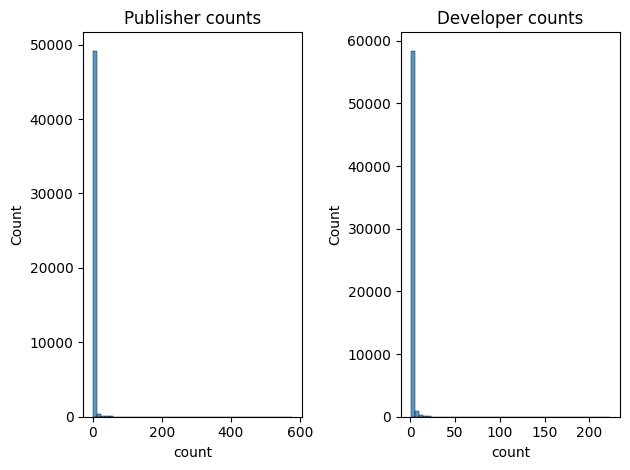

In [ ]:
fig, axes = plt.subplots(1, 2)
sns.histplot(df.publishers.explode().value_counts(), bins=50, ax=axes[0])
axes[0].set_title("Publisher counts")
sns.histplot(df.developers.explode().value_counts(), bins=50, ax=axes[1])
axes[1].set_title("Developer counts")
plt.tight_layout()

The distributions have long tails, so we can also transform in the frequency encoder

In [ ]:
class FreqEnc(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.freq = np.log1p(X.explode().value_counts())
        self.input_col = X.name if hasattr(X, 'name') else None #takes the name of the variable if it has an attribute called 'name'
        return self
    
    def transform(self, X):
        output = X.apply(lambda lst: max([self.freq.get(x,0) for x in lst]))
        return output.to_numpy().reshape(-1,1) #reshaping is necessary to get it to be a column
    
    def get_feature_names_out(self, input_features=None):
        return np.array([self.input_col or 'freq_encoded']) #returns the feature name or 'freq_encoded' if name is None

## Define the Preprocessing Pipeline
Now that the wrappers are defined, we can add them to a column transformer:

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer

numeric = df_train.select_dtypes(exclude='object').columns.drop('price').to_list()

preprocess = ColumnTransformer(transformers=[
    ('log_price', FunctionTransformer(func=np.log1p, feature_names_out='one-to-one'), ['price']),
    ('date',ReleaseDateTransformer(), 'release_date'),
    ('genres', MLBTransformer(), 'genres'),
    ('categories', MLBTransformer(), 'categories'),
    ('developers', FreqEnc(), 'developers'),
    ('publishers', FreqEnc(), 'publishers'),
    ('num','passthrough', numeric)
])

Now we can create pipelines for different models
Since it's a regression problem, I'll focus on using different tree-based models

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

def build_pipeline(model):
    pipeline = Pipeline([
        ('preprocess', preprocess),
        ('model', model)
    ])
    return pipeline

pipe_dt = build_pipeline(DecisionTreeRegressor(random_state=234))
pipe_rf = build_pipeline(RandomForestRegressor(random_state=234))
pipe_xgb = build_pipeline(XGBRegressor(random_state=234))

# Hyperparameter Tuning
Define parameter ranges per model

In [ ]:
import scipy.stats as stats

params_dt = {
    'model__max_depth': [2,3,4,5,6,7,8,9,10,15,20,None],
    'model__min_samples_split': stats.randint(2, 20),
    'model__min_samples_leaf': stats.randint(1, 10),
    'model__max_features': ['sqrt', 'log2', 0.5, 0.7, 1.0]
}

params_rf = {
    'model__n_estimators': stats.randint(100,2000),
    'model__max_depth': [2,3,4,5,6,7,8,9,10,15,20],
    'model__min_samples_split': stats.randint(2,20),
    'model__min_samples_leaf': stats.randint(1, 10),
    'model__max_features': ['sqrt', 'log2', 0.5, 0.7, 1.0]
}

params_xgb = {
    'model__learning_rate': stats.loguniform(0.005, 0.3), #0.3 is the default so set it as max
    'model__max_depth': [2,3,4,5,6,7,8,9,10],
    'model__n_estimators': stats.randint(10,1000),
    'model__subsample': stats.uniform(0.5,0.5), #fraction of rows (samples) to use in each three
    'model__colsample_bytree': stats.uniform(0.5,0.5), #fraction of columns randomly used by each tree
    'model__gamma': stats.uniform(0.0, 5.0),
    'model__min_child_weight': stats.randint(1, 10),
    'model__reg_alpha': stats.uniform(0.0, 1.0),
    'model__reg_lambda': stats.uniform(0.0, 2.0)
}

Wrap in dictionaries for pipeline and parameter range

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import root_mean_squared_error
from joblib import dump

pipelines = {
    'DecisionTree':( pipe_dt, params_dt),
    'RandomForest': (pipe_rf, params_rf),
    'XGBoost': (pipe_xgb, params_xgb)
}

results = []
search_results={}
for name, (pipe, params) in pipelines.items():
    print(f'### Training {name} ###')

    tune = RandomizedSearchCV(
        estimator=pipe, 
        param_distributions=params,
        n_iter=50,
        cv=5,
        scoring='neg_root_mean_squared_error',
        n_jobs = 6,
        random_state=234,
        return_train_score=True,
        verbose=1
    )

    tune.fit(df_train, y_train)
    y_val_pred=tune.predict(df_val)
    rmse_val=root_mean_squared_error(y_val, y_val_pred)

    search_results[name]=tune
    results.append({
        'model': name,
        'best_rmse_cv': -tune.best_score_,
        'rmse_val': rmse_val,
        'best_params': tune.best_params_,
        'best_estimator': tune.best_estimator_
    })

results_df = pd.DataFrame(results).sort_values('rmse_val').reset_index(drop=True)
with open('search_results.pkl', 'wb') as f:
    dump(search_results, f)

### Training DecisionTree ###
Fitting 5 folds for each of 50 candidates, totalling 250 fits
### Training RandomForest ###
Fitting 5 folds for each of 50 candidates, totalling 250 fits
### Training XGBoost ###
Fitting 5 folds for each of 50 candidates, totalling 250 fits


# Results

## Plot 1 - Bar plot
This plot shows model performance (validation RMSE) for the three different models compared to a NULL model of predictions of mean y_train
The RMSE for the null model is around 3, while all three models have lower validation RMSE. This means that the models are better than the NULL model. RF and XGB are very close, but DTs are not very different

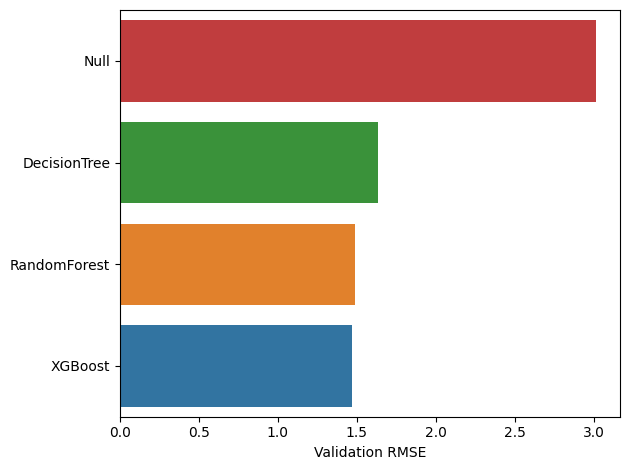

In [ ]:
plot1=results
plot1.append({
    'model':'Null',
    'best_rmse_cv':root_mean_squared_error(y_val, np.repeat(y_train.mean(), len(y_val))),
    'rmse_val':root_mean_squared_error(y_val, np.repeat(y_train.mean(), len(y_val)))
})
plot1_df = pd.DataFrame(plot1).sort_values('rmse_val').reset_index(drop=True)

sns.barplot(plot1_df, x='rmse_val', y='model', hue='model')
plt.ylabel('')
plt.xlabel('Validation RMSE')
plt.tight_layout()
plt.gca().invert_yaxis()
plt.show()

## Plot 2 - Boxplot
This plot is a boxplot of train and validation RMSE across different parameter combinations
It shows model stability
XGB is not only the model with the lowest training RMSE values, but also a much smaller spread in the validation, making it the best model in this case

In [ ]:
all_cv_results =[]
for model_name, search_res in search_results.items():
    cv_results = pd.DataFrame(search_res.cv_results_) # converts dictionary cv_results_ to DataFrame

    cv_results['model'] = model_name
    cv_results['mean_train_rmse'] = -cv_results['mean_train_score'] #the scores are negative in scikitlearn
    cv_results['mean_val_rmse'] = -cv_results['mean_test_score']

    all_cv_results.append(cv_results)

all_cv_results = pd.concat(all_cv_results, ignore_index=True)

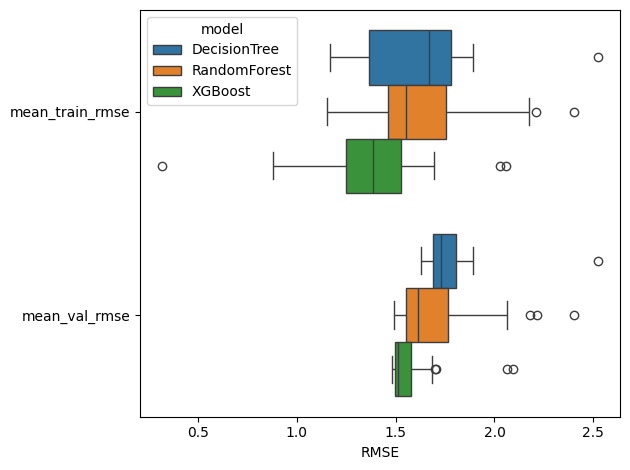

In [ ]:
plot2_df=all_cv_results.melt(
    id_vars=['model'],
    value_vars=['mean_train_rmse', 'mean_val_rmse'],
    var_name='metric',
    value_name='value'
)
sns.boxplot(plot2_df, x='value', y='metric', hue='model', dodge=True)
plt.ylabel('')
plt.xlabel('RMSE')
plt.tight_layout()
plt.show()

## Plot 3 - Validation Plot
This plot shows the validation plot of the tuned parameters for the XGBoost model, showing the training and validation RMSE across parameter levels

In [ ]:
param_cols = all_cv_results.columns[all_cv_results.columns.str.startswith('param_')]

all_cv_results_long = all_cv_results.melt(
    id_vars=['model', 'mean_train_rmse', 'mean_val_rmse'],
    value_vars=param_cols,
    var_name='param_name',
    value_name='param_value'
)

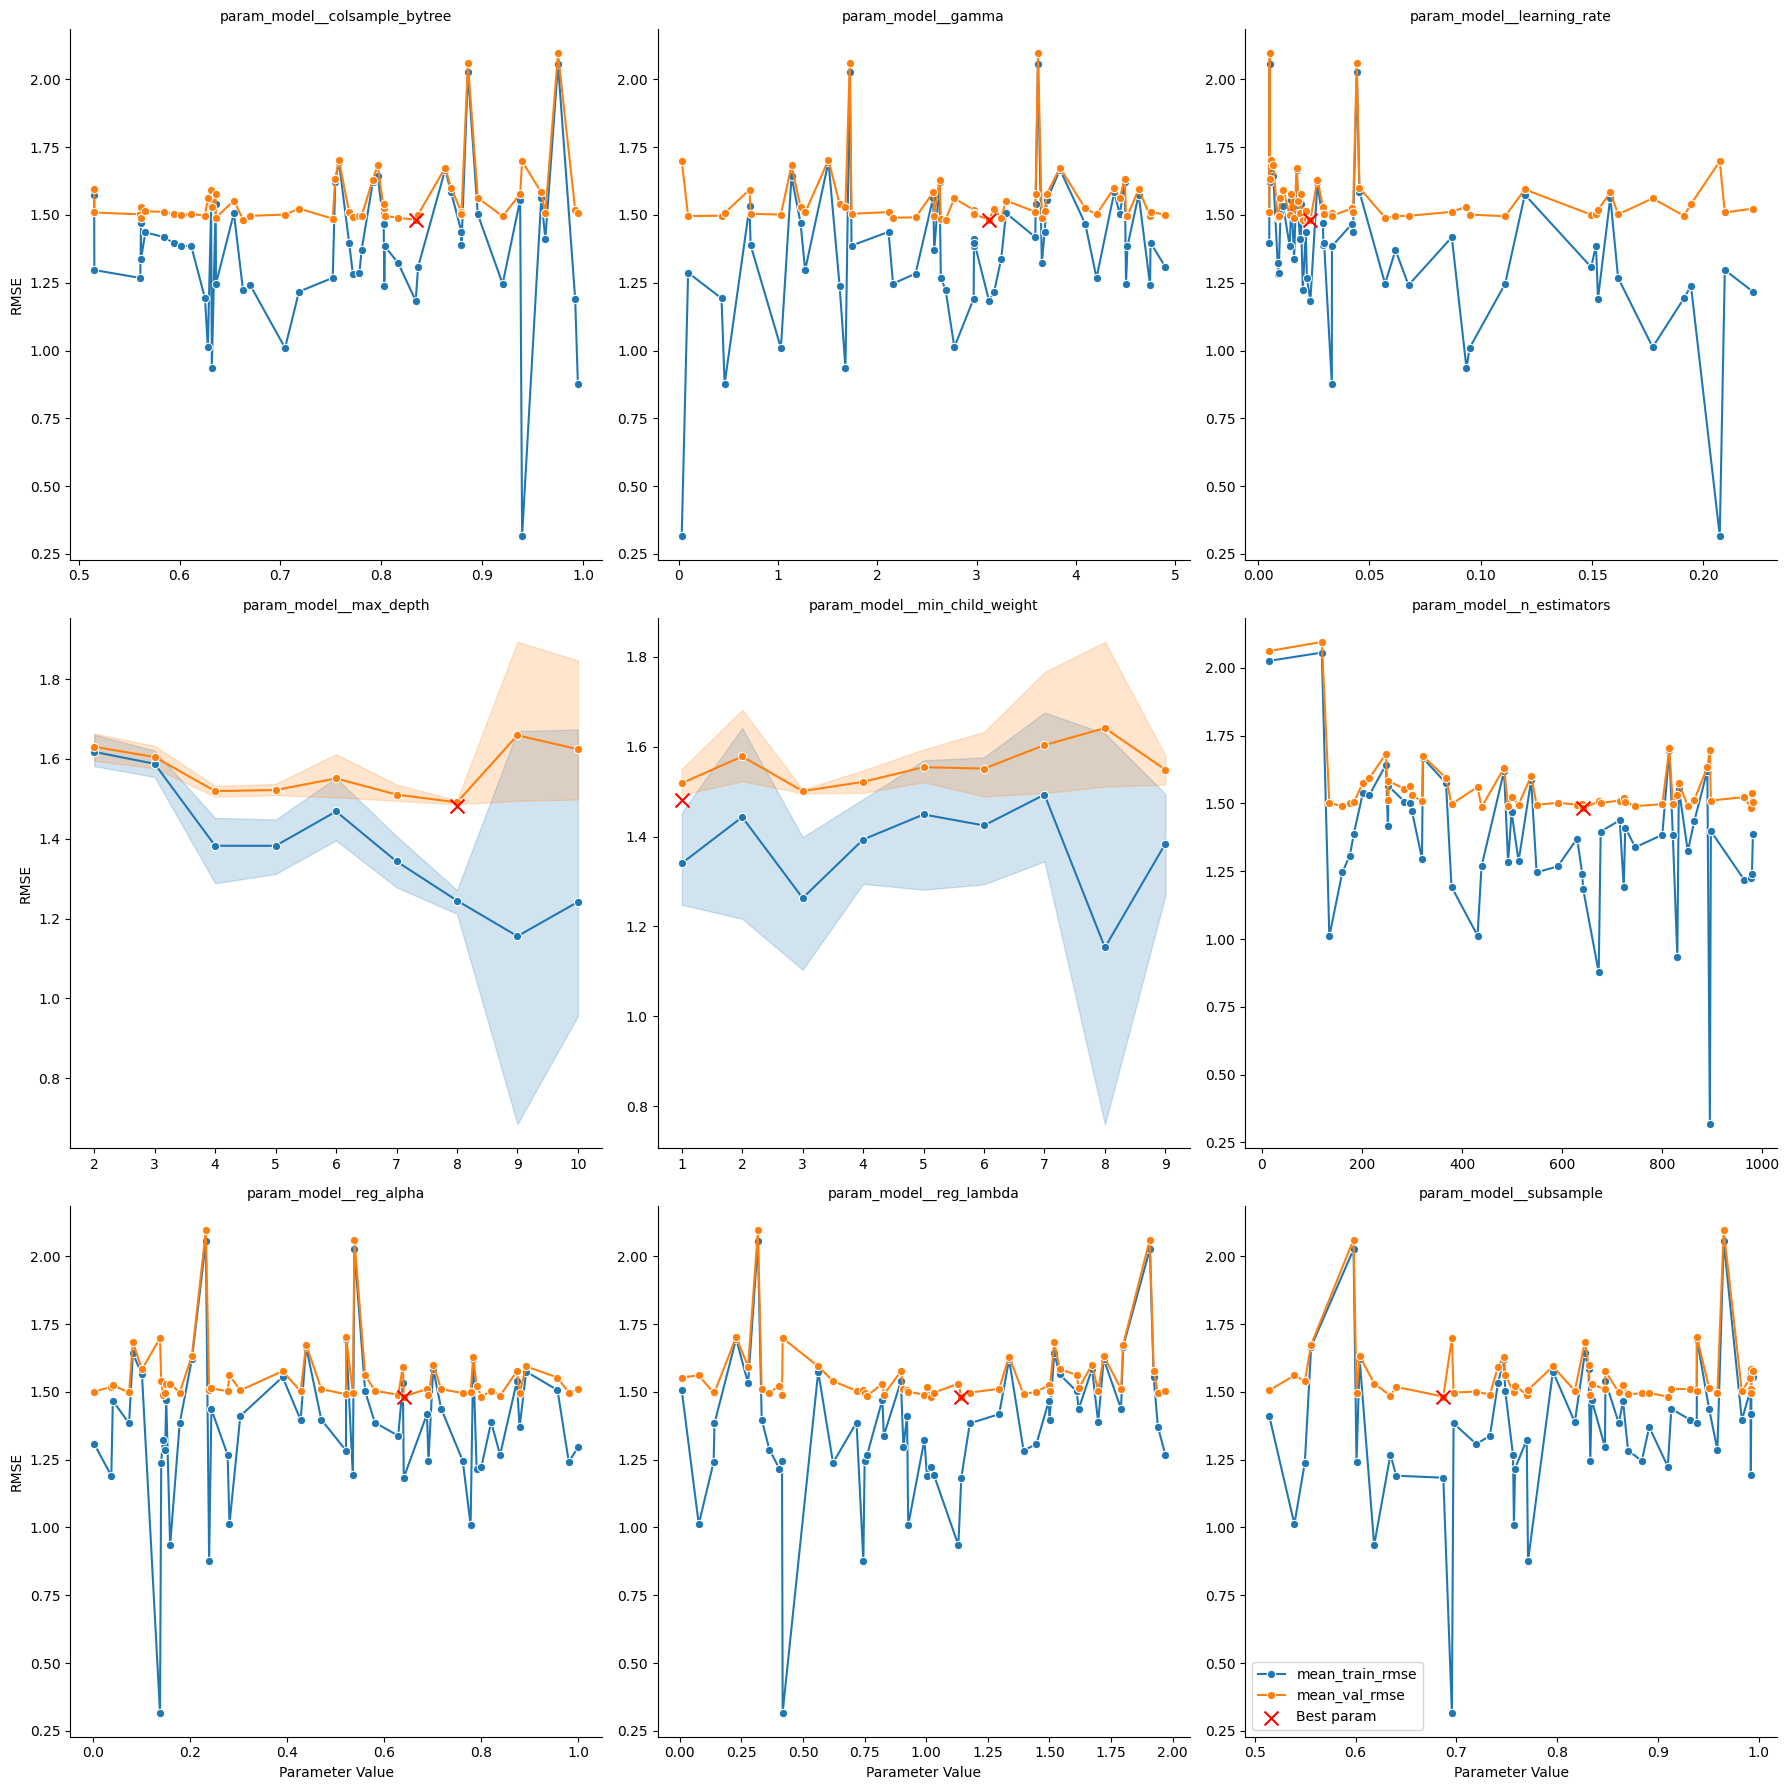

In [ ]:
xgb_subset = all_cv_results_long[all_cv_results_long['model'] == 'XGBoost']
best_params = search_results['XGBoost'].best_params_
used_params = pd.Series(best_params.keys())
used_params = ('param_' + used_params).tolist()
xgb_subset = xgb_subset[xgb_subset['param_name'].isin(used_params)].copy()

xgb_melt = xgb_subset.melt(
    id_vars=['param_name', 'param_value'],
    value_vars=['mean_train_rmse', 'mean_val_rmse'],
    var_name='metric',
    value_name='rmse'
)

g = sns.FacetGrid(
    data=xgb_melt,
    col='param_name',
    hue='metric',
    sharex=False,
    sharey=False,
    col_wrap=3, # Arrange into a 2x2 grid
    height=6,
    col_order=used_params
)

g.map_dataframe(sns.lineplot, 'param_value', 'rmse', marker='o')

# Add best parameter marker to each facet
for ax, pname in zip(g.axes.flatten(), used_params):
    idx = xgb_melt[(xgb_melt['param_name'] == pname) & (xgb_melt['metric'] == 'mean_val_rmse')].idxmin()['rmse']
    x = xgb_melt.loc[idx,'param_value']
    y = xgb_melt.loc[idx,'rmse']
    ax.scatter(x, y, color='red', s=100, marker='x', zorder=5, label='Best param')

plt.legend()
g.set_titles(col_template='{col_name}')
g.set_axis_labels('Parameter Value', 'RMSE')
g.tight_layout()
plt.show()

## Feature Importance
### Base Feature importances

The feature importance values here are extracted from the models directly

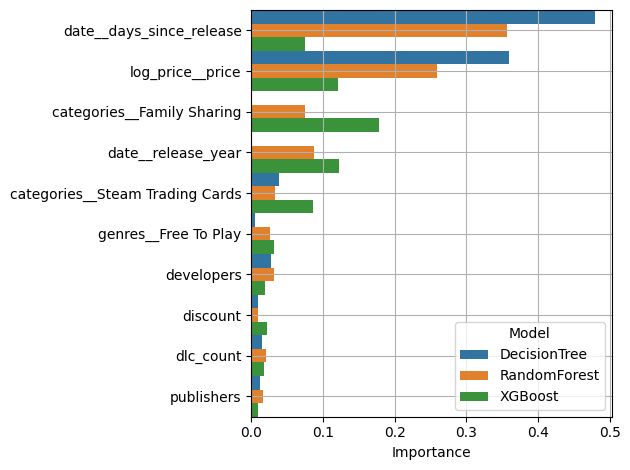

In [ ]:
feature_importance=[]
for model_name, search_res in search_results.items():
    best_model = search_res.best_estimator_
    feat_names = pd.Series(best_model.named_steps['preprocess'].get_feature_names_out()).str.replace(pat=r'(num|publishers|developers)__', regex=True, repl='')
    feat_imp = best_model.named_steps['model'].feature_importances_

    df = pd.DataFrame({
        'model':model_name,
        'feature':feat_names,
        'importance':feat_imp
    })

    feature_importance.append(df)

feature_importance = pd.concat(feature_importance, ignore_index=True).sort_values('importance', ascending=False)

top_features = (
    feature_importance
    .groupby('feature')['importance']
    .mean()  # or mean — doesn't matter, just for ranking
    .sort_values(ascending=False)
    .head(10)
    .index
)

plot_df=feature_importance[feature_importance['feature'].isin(top_features)]


sns.barplot(
    data = plot_df,
    x='importance',
    y='feature',
    hue='model',
    dodge=True,
    errorbar=None,
    width=1
)
plt.ylabel('')
plt.xlabel('Importance')
plt.legend(title='Model', loc='best')
plt.tight_layout()
plt.grid(visible=True, which='both')
plt.yticks()
plt.show()

### Permutation Based Feature Importance
For permutation-based feature importance, the values of each feature are permuted and performance is assessed.
The idea is that upon permutationm of a given feature values, if the model error increasess, the feature is deemed important.
So more important features result in greater error.
Differently from the base feature importances, these values are much more aligned across models.
However, what this doesn't tell us is how the predictions are affected by these values. For that we look into the SHAP values

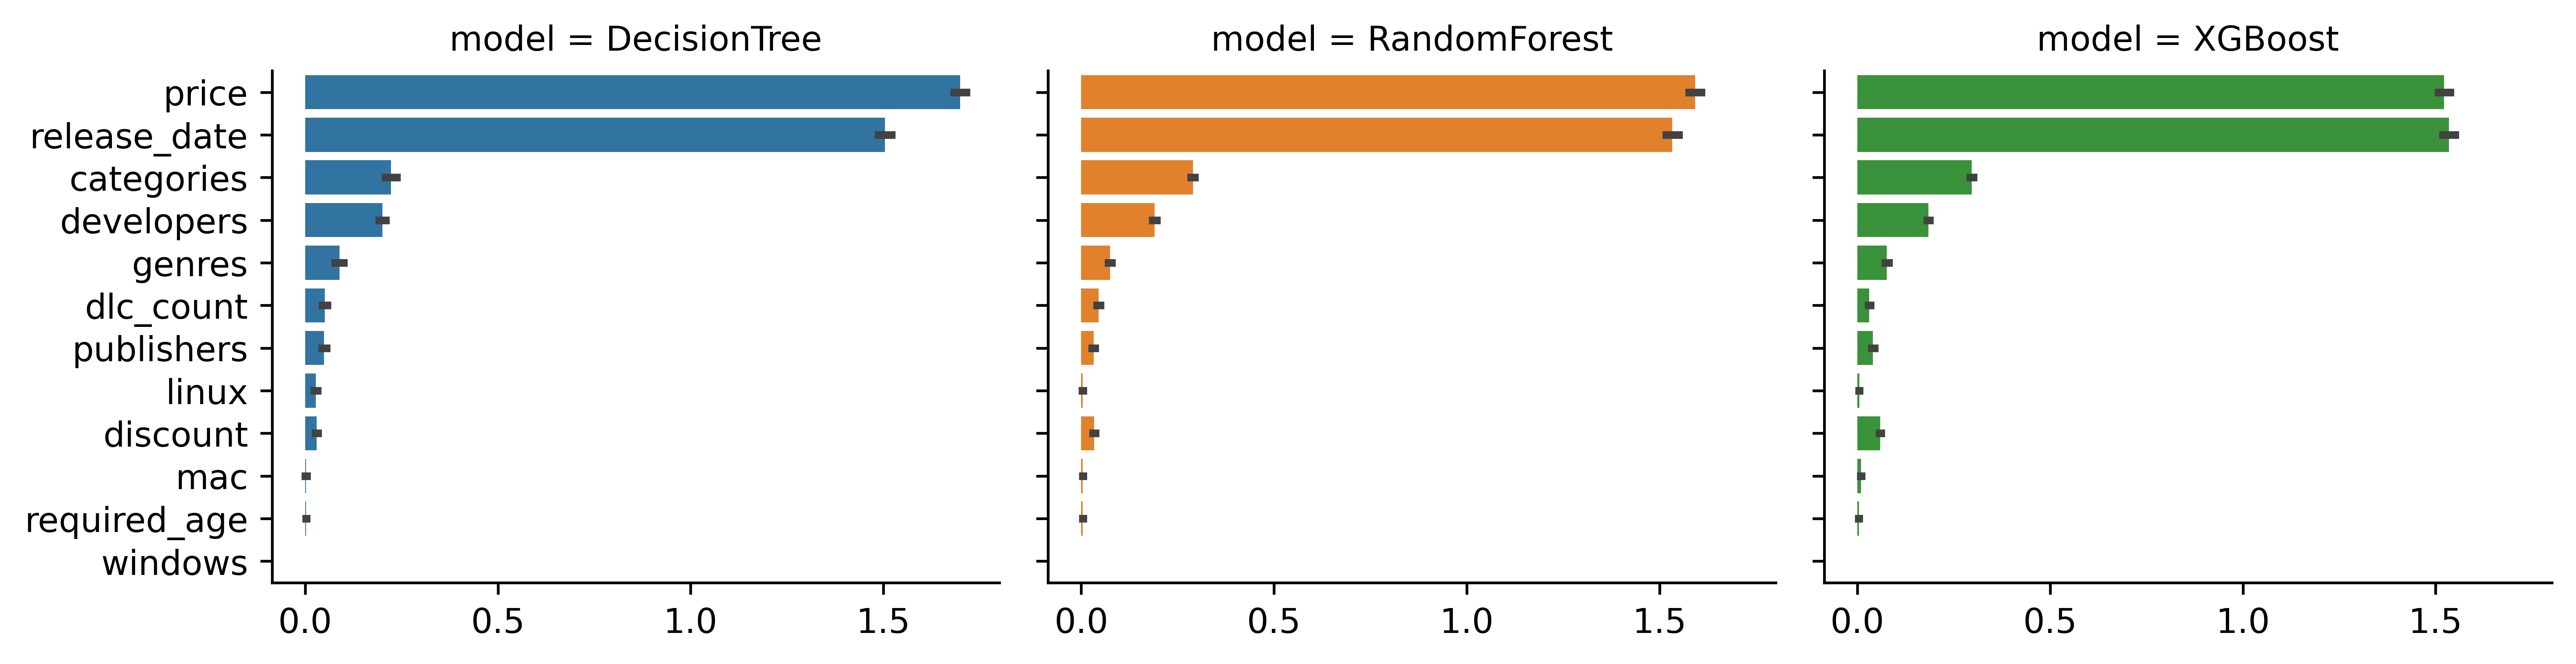

In [ ]:
from sklearn.inspection import permutation_importance

perm_list = []
perm_results={}
for model_name, search in search_results.items():
    best_model = search.best_estimator_
    result = permutation_importance(
        estimator=best_model, 
        X=df_val, 
        y=y_val, 
        n_repeats=10, 
        scoring='neg_root_mean_squared_error', 
        n_jobs=6, 
        random_state=234
    )

    perm_results[model_name]=result

    df = pd.DataFrame(result.importances.T, columns=df_val.columns) #importances come in shape(features x resamples) so it needs to be transposed
    df = df.melt(var_name='feature', value_name='importance')
    df['model']=model_name
    perm_list.append(df)

perm_imp_df = pd.concat(perm_list, ignore_index=True).sort_values('importance', ascending=False)

plot=sns.FacetGrid(data=perm_imp_df, col='model', hue='model', sharex=True, sharey=True, aspect=1.2)
plot.map_dataframe(sns.barplot, x='importance', y='feature', errorbar='sd')
plot.figure.set_dpi(600)
plot.tight_layout()
plot.set_xlabels('')
plot.set_ylabels('')

### SHAP

SHAP (SHapley Additive exPlanations) is a method based on game theory and originally designed to explain individual predictions.
It shows how much each feature pushes the prediction up or down.
A prediction is treated as `baseline + sum(shap)`, so it is easy to understand feature contributions to the outcome

In [ ]:
import shap

#shap doesn't take pipelines, so we need to separate the model and preprocess the data 

best_xgb = search_results['XGBoost'].best_estimator_
model = best_xgb.named_steps['model']
preprocessor = best_xgb.named_steps['preprocess']
feature_names = preprocessor.get_feature_names_out()

X_val_transformed = pd.DataFrame(preprocessor.transform(df_val), columns=feature_names).astype('float')

explainer = shap.TreeExplainer(
    model=model
)

explanation = explainer(X_val_transformed)

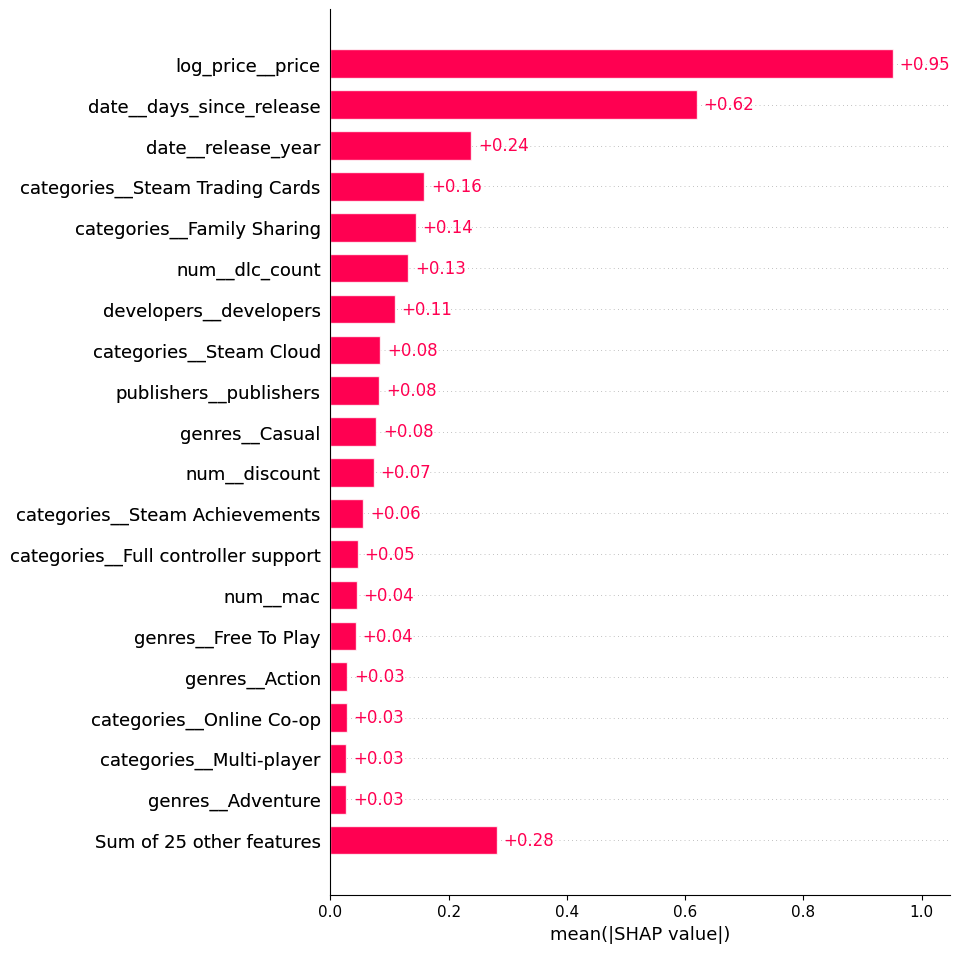

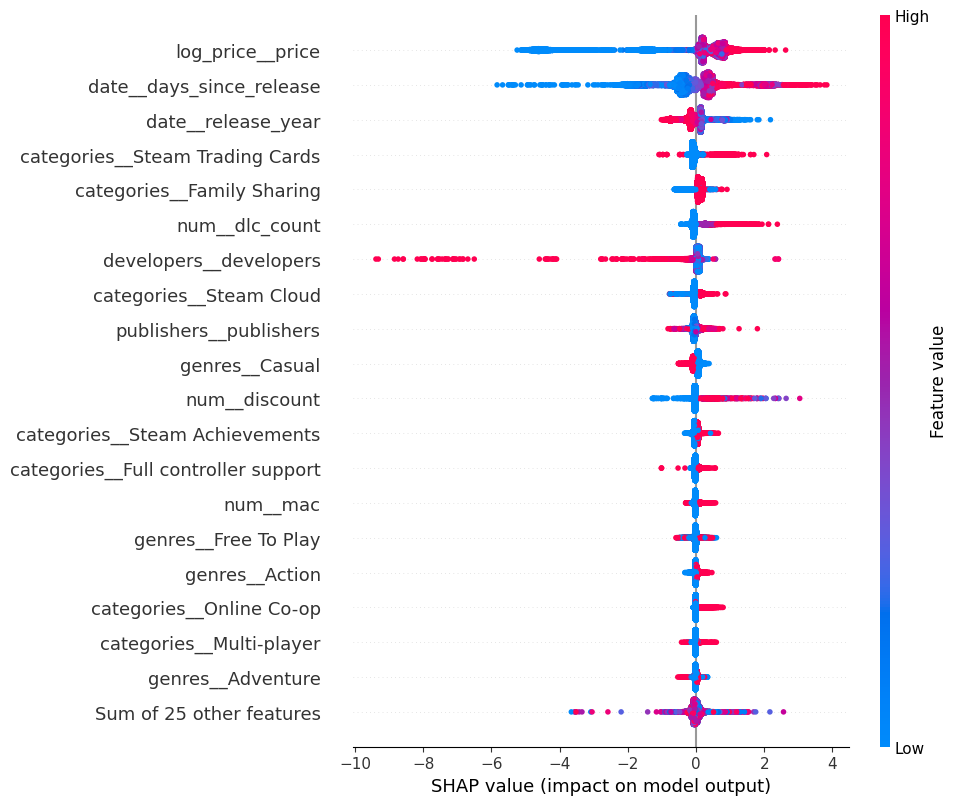

In [ ]:
shap.plots.bar(explanation, max_display=20)
shap.plots.beeswarm(explanation, max_display=20)

# Final Model
The best model was the xgboost.
As a final step, we can retrain on the full trainin data and calculate the RMSE on the test set

In [ ]:
import json
best_params = search_results['XGBoost'].best_params_
with open('best_xgboost_params.json', 'w') as f:
    json.dump(best_params, f, indent=4)

In [ ]:
final_xgb = search_results['XGBoost'].best_estimator_
final_xgb.fit(df_full_train, y_full_train)

y_test_pred = final_xgb.predict(df_test)
test_rmse = root_mean_squared_error(y_test, y_test_pred)

final_results = pd.DataFrame({
    'model': 'XGBoost',
    'RMSE_CV': results_df['best_rmse_cv'][results_df['model']=='XGBoost'],
    'RMSE_Val': results_df['rmse_val'][results_df['model']=='XGBoost'],
    'RMSE_Test': test_rmse
})

final_results

,model,RMSE_CV,RMSE_Val,RMSE_Test
0,XGBoost,1.482491,1.472224,1.481398


We can train a final SHAP explainer on the full data

In [ ]:
model = final_xgb.named_steps['model']
preprocessor = final_xgb.named_steps['preprocess']
feature_names = preprocessor.get_feature_names_out()

X_test_transformed = pd.DataFrame(preprocessor.transform(df_test), columns=feature_names).astype('float')

explainer = shap.TreeExplainer(
    model=model
)

explanation = explainer(X_test_transformed)

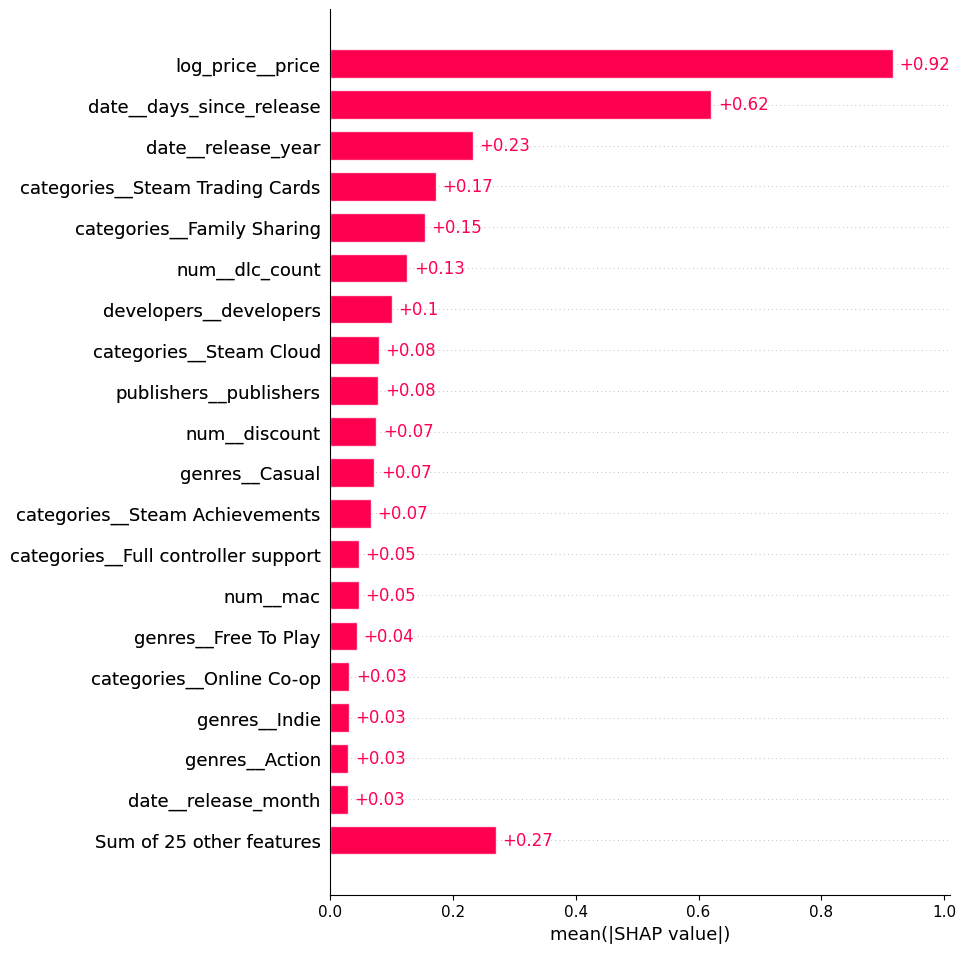

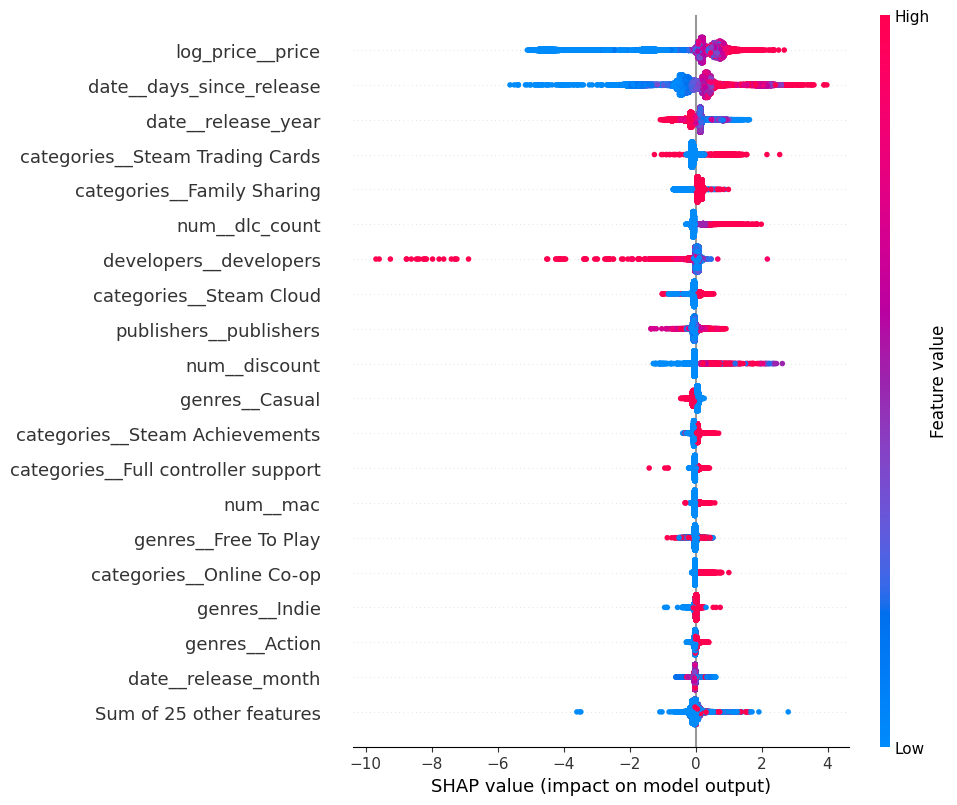

In [ ]:
shap.plots.bar(explanation, max_display=20)
shap.plots.beeswarm(explanation, max_display=20)